# Unbinned maximum likelihood fit

The probability density function for the distribution of an angle $\alpha$ is given by

$ f(x; a) = \frac{1 + a x}{2}, \quad x = \cos \alpha$.

The parameter $a$ is in the range $-1 \le a \le 1$.

## Tasks

a) Determine the maximum-likelihood estimate $\hat a$ of the parameter $a$ and its uncertainty from the provided data sample using a numerical minimization tool, e.g., `iminuit` (see comments below).

b) Plot the histogram representation of the data along with the fit function.

c) Determine the uncertainties $\sigma_a^-$ and $\sigma_a^+$ defined by

$$ \ln L (\hat a \pm \sigma_a) =  \ln L_\mathrm{max} - \frac{1}{2} $$

Compare your result with the result of `iminuit`'s `minos()` routine. Reduce the sample size of the data set by only taking the first $n$ events (`x[:n]`). At approximately which value of $n$ is the difference between $\sigma_a^-$ and $\sigma_a^+$ bigger than 5\%? 

Use the data generation provided in the notebook `S01_ml_02_generate_data.ipynb`. It is recommended to actually generate a `CSV` file and read it back here. You don't necessarily have to hand in your generated data; the tutors can generate their own and since your implemented procedure is generic, it should work with any other dataset generated with `S01_ml_02_generate_data.ipynb`.


### Hints

It is recommended to not start coding right away. Try to really understand how the Likelihood looks first. Realize, what the Likelihood is a function of and what it describes.

Also, the function imported as `from scipy.optimize import brentq` might come in handy.


## Comments on Python's `iminuit`

The KIP service has iminuit version 1.3.8. Please note that the most recent version is $\geq2.0.0$ and that the [documentation](https://iminuit.readthedocs.io/en/stable/) applies to *that* version. Some backward-incompatible changes have been introduced, some of which changed some interfaces. For your tasks that mainly affects the `minuit.Minuit` constructor. The following shows the construction of a `Minuit` object for version 1.3.8 (in case you use the KIP service or a version $<2.0.0$) and $\geq2.0.0$ (in case you use another service implementing a higher version), respectively.
```python
from iminuit import Minuit

def func(par1, par2, ..., parN):
    return minimise_something(par1, par2, ..., parN)

# least squares method: errordef=1
# likelihood method: errordef=0.5
m = Minuit(func, par1=0.1, par2=0.1, ..., parN=0.1, errordef=1)
```

And this would be the equivalent workflow for versions >2.0.0
```python
from iminuit import Minuit

def func(par1, par2, ..., parN):
    return minimise_something(par1, par2, ..., parN)

# least squares method: errordef=Minuit.LEAST_SQUARES
# likelihood method: errordef=Minuit.LIKELIHOOD

# add errordef as an attribute of your defined minimisation function which will be checked for when optimised
func.errordef = Minuit.LEAST_SQUARES
m = Minuit(func, par1=0.1, par2=0.1, ..., parN=0.1)
```

Another (potenitally) Jupiter related *feature* is the fact that `m.migrad()`, `m.matrix()`, `m.minos()` etc. can yield a nice summary of the respective procedure. However, in order to show it, either of these methods (and potentially others in case you use them) have to be *the last line of a code cell*. If there is *anything* coming afterwards, the output will not be printed, hence, for anything that follows, it is recommended to start a new code cell.

In [317]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit

In [318]:
x = np.loadtxt("ml_fit_data.csv")
#x = x[:30]

### Solution
#### a) Determine the maximum-likelihood estimate $\hat a$ of the parameter $a$ and its uncertainty from the provided data sample

In [319]:
# likelihood function
def density(x, a):
    return (1+a*x)/2

def likelihood(a):
    f=1
    for x_i in x:
        f=f*density(x_i, a)
    return f

# minimization using iminuit
errordef=Minuit.LIKELIHOOD # likelihood method
likelihood.errordef = Minuit.LEAST_SQUARES
m = Minuit(likelihood, a=0.5)
m.migrad()

a=m.values['a']

print(f"a = {m.values['a']} ± {m.errors['a']}")

a = 0.1280099781258186 ± 0.0


#### b) Plot the histogram representation of the data along with the fit function.

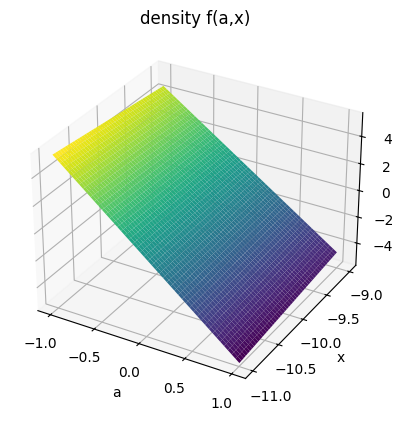

In [320]:
# Plot of density function
a = np.array([0.128])

# Plot the function f(a,x) over both a and x
a_0 = np.linspace(-1, 1)
x_0 = np.linspace(np.min(x), np.max(x))

A_0, X_0= np.meshgrid(a_0, x_0)
Z_0 = density(A_0, X_0)-(1/2)

ax = plt.axes(projection='3d')
ax.plot_surface(A_0, X_0, Z_0, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

ax.set_title('density f(a,x)')
ax.set_xlabel('a')
ax.set_ylabel('x');
ax.set_zlabel('f(a,x)');

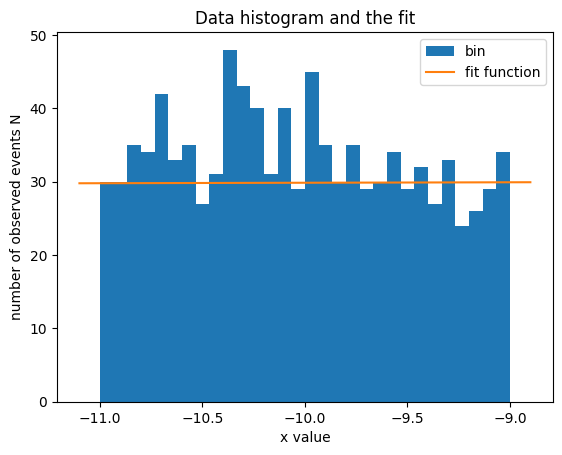

In [321]:
# histogram
plt.hist(x, range=[-11, -9], bins=30, label='bin')
plt.xlabel('x value')
plt.ylabel('number of observed events N')
plt.title('Data histogram and the fit')

def P(x, dx):
    return density(x, a)*dx

dx=2/30
x_range=np.linspace(-11.1, -8.9)
plt.plot(x_range, density(x_range, a)+30, label='fit function')    # Um die Fit-Linie zu sehen wird manuell ein Wert zusammen addiert

plt.legend()

From the 3D fit-function plot and the combined plot with the histogram, it can be observed that the data is almost uniformly distributed (due to the small value of a), and the density function can be considered almost "flat." However, it is possible that there was an error in the data generation, as the value of $x = \cos(\alpha)$ must always be less than 1. Yet, this is not the case with the data, where x is distributed between -9 and -11, which can also be seen visually in the graph.

### c) Determine the uncertainties $\sigma_a^-$ and $\sigma_a^+$ defined by

$$ \ln L (\hat a \pm \sigma_a) =  \ln L_\mathrm{max} - \frac{1}{2} $$

Compare your result with the result of `iminuit`'s `minos()` routine. Reduce the sample size of the data set by only taking the first $n$ events (`x[:n]`). At approximately which value of $n$ is the difference between $\sigma_a^-$ and $\sigma_a^+$ bigger than 5\%? 

In [322]:
# Define the log-likelihood function
def log_likelihood(a, data):
    likelihoods = np.array([density(x_i, a) for x_i in data])
    return -np.sum(np.log(likelihoods))                              # Negative log-likelihood for minimization

# Fit data using iminuit
def kein_Bock_mehr(n):
    data = x[:n]
    m = Minuit(lambda a: log_likelihood(a, data), a=0)
    m.migrad() 
    m.minos()    # Calculate the asymmetric uncertainties

    a_hat = m.values['a']
    sigma_a_minus = m.merrors['a'].lower
    sigma_a_plus = m.merrors['a'].upper

    return a_hat, sigma_a_minus, sigma_a_plus

np.random.seed(0)  # For reproducibility
n_total = 1000  # total number of samples
x = np.random.uniform(-1, 1, n_total)

# Compare results for different values of n
for n in [30, 49, 50, 80, 100, 150]:
    a_hat, sigma_a_minus, sigma_a_plus = kein_Bock_mehr(n)
    
    if a_hat is not None:
        diff = 100 * np.sqrt(((sigma_a_plus + sigma_a_minus) / (sigma_a_plus - sigma_a_minus))**2)
        print(f"For n={n}: a={a_hat:.4f}, sigma_a^−={sigma_a_minus:.4f}, sigma_a^+={sigma_a_plus:.4f}, difference={diff:.2f}%")


For n=30: a=0.4558, sigma_a^−=-0.4232, sigma_a^+=0.3394, difference=10.99%
For n=49: a=0.2630, sigma_a^−=-0.3582, sigma_a^+=0.3218, difference=5.35%
For n=50: a=0.2453, sigma_a^−=-0.3585, sigma_a^+=0.3249, difference=4.92%
For n=80: a=-0.0677, sigma_a^−=-0.2673, sigma_a^+=0.2712, difference=0.73%
For n=100: a=-0.1622, sigma_a^−=-0.2377, sigma_a^+=0.2438, difference=1.26%
For n=150: a=0.0656, sigma_a^−=-0.2060, sigma_a^+=0.2028, difference=0.78%


At approximately $n=50$ is the difference between $\sigma_a^-$ and $\sigma_a^+$ bigger than 5\%, and the smaller the value n, the bigger the difference, due to the statistic error.

alternative we can calculate in a analytic way:

First, let's find better equations for \( a = 0 \):

$$
\ln L_\mathrm{max} - \frac{1}{2} = \sum_{i=1}^n \ln\frac{1}{2} - \frac{1}{2} = - n \ln 2  -\frac{1}{2}
$$

$$
\ln L (\hat{a} \pm \sigma_a) = \sum_{i=1}^n \ln\frac{1 \pm \sigma \cdot x}{2} = \sum_{i=1}^n \ln (1 \pm \sigma \cdot x) - n \ln 2
$$

The two equations implify:

$$
\sum_{i=1}^n \ln (1 \pm \sigma \cdot x) = -\frac{1}{2}  \,\,\,  (*)
$$

To calculate the logarithm, use the following approximation for $-1 < y < 1$:

$$
\ln(1 + y) = \sum_{k=1}^{\infty} (-1)^{k+1} \frac{y^{k}}{k} \approx \sum_{k=1}^{4} (-1)^{k+1} \frac{y^{k}}{k} + O(5) \,\,\, (**)
$$


In [326]:
import sympy as sp
from sympy import Symbol, log, solve

x_30 = x[:30]
#print(x_30)
# Define symbols
sigma_positive = Symbol('sigma_positive')
sigma_negative = Symbol('sigma_negative')

def equation1(sigma_positive, x, m): # equation (**)
    total_sum1 = 1/2  # Initialize with 1/2 as a sympy symbol
    for i in range(len(x)):
        for j in range(len(m)):
            total_sum1 += ((-1)**(m[j]+1)) *(sigma_positive*x[i])**m[j]/m[j]
    return total_sum1

def equation2(sigma_negative, x, m): # equation (**)
    total_sum2 = 1/2 
    for i in range(len(x)):
        for j in range(len(m)):
            total_sum2 += (-1)**(m[j]+1) *(sigma_negative*x[i])**m[j]/m[j]
    return total_sum2

# Solve equations
m = [1, 2, 3, 4]
sigma_max = solve(equation1(sigma_positive, x_30, m), sigma_positive, domain=sp.S.Reals)
sigma_min = solve(equation2(sigma_negative, x_30, m), sigma_negative, domain=sp.S.Reals)

# Filtern der reellen Lösungen
reelle_sigma_max = np.max([sol.evalf() for sol in sigma_max if sp.im(sol) == 0])
reelle_sigma_min = np.min([sol.evalf() for sol in sigma_min if sp.im(sol) == 0])

print(f'Reelle Lösung für sigma_positive: {reelle_sigma_max}')
print(f'Reelle Lösung für sigma_negative: {reelle_sigma_min}')

Reelle Lösung für sigma_positive: 0.925959873931855
Reelle Lösung für sigma_negative: -0.0934269557990564
